In [ ]:
data.reset_index()

In [3]:
import pandas as pd
data = pd.read_csv('organisations.csv')
features = pd.read_csv('features.csv')
rubrics = pd.read_csv('rubrics.csv')

In [3]:
data['rubrics_id']=data['rubrics_id'].str.split(' ')

In [4]:
rubric_dict = dict(zip(rubrics['rubric_id'],rubrics['rubric_name']))
features_dict = dict(zip(features['feature_id'], features['feature_name']))

<Axes: xlabel='average_bill', ylabel='rating'>

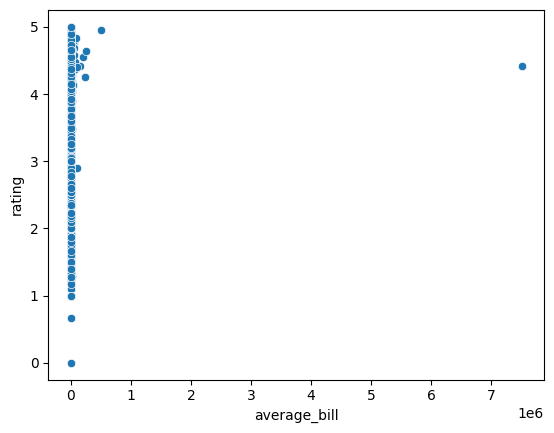

In [5]:
import seaborn as sns

sns.scatterplot(x='average_bill', y='rating', data=data)

In [6]:
data.isna().sum()

org_id              0
city                0
average_bill    35561
rating          13731
rubrics_id          0
features_id     11049
dtype: int64

In [4]:
data_cleaned = data.dropna(subset=['average_bill'])
data_cleaned = data_cleaned.loc[data_cleaned['average_bill']<=2500]
data_cleaned.shape[0]

32136

In [9]:
data_cleaned[data_cleaned['city']=='msk']['average_bill'].mean() - data_cleaned[data_cleaned['city']=='spb']['average_bill'].mean()

116.43756751957676

In [ ]:
data_cleaned['rubrics_id'].tolist()

In [9]:
# Функция для замены идентификаторов на значения из словаря
def decode_rubrics(rubrics_list):
    return [rubric_dict.get(int(rubric_id), 'Неизвестно') for rubric_id in rubrics_list]

# Добавляем новый столбец с расшифрованными значениями
data_cleaned['rubrics_name'] = data_cleaned['rubrics_id'].apply(decode_rubrics)
data_cleaned.head(3)

,org_id,city,average_bill,rating,rubrics_id,features_id,rubrics_name
0,15903868628669802651,msk,1500.0,4.270968,"[30776, 30774]",3501685156 3501779478 20422 3502045016 3502045...,"[Ресторан, Кафе]"
1,16076540698036998306,msk,500.0,4.375000,[30771],1509 1082283206 273469383 10462 11617 35017794...,[Быстрое питание]
2,8129364761615040323,msk,500.0,4.000000,[31495],10462 11177 11617 11629 1416 1018 11704 11867 ...,[Кофейня]


In [ ]:
data_cleaned[data_cleaned['rubrics_name'].apply(lambda x: 'Кафе' in x)]

In [ ]:
data_cleaned[data_cleaned['rubrics_name'].apply(lambda x: x==['Кафе'])]

In [19]:
data_cleaned[(data_cleaned['city'] == 'msk') & (data_cleaned['rubrics_name'].apply(lambda x: 'Кафе' in x))]['average_bill'].mean() - data_cleaned[(data_cleaned['city'] == 'spb') & (data_cleaned['rubrics_name'].apply(lambda x: 'Кафе' in x))]['average_bill'].mean()

142.40368719534695

In [34]:
mean_bill = data_cleaned[data_cleaned['rubrics_name'].apply(lambda x: x == ['Кафе'])].groupby('city')['average_bill'].mean().get('msk') - data_cleaned[data_cleaned['rubrics_name'].apply(lambda x: x == ['Кафе'])].groupby('city')['average_bill'].mean().get('spb')
mean_bill

112.04464763386989

<Axes: xlabel='average_bill', ylabel='Count'>

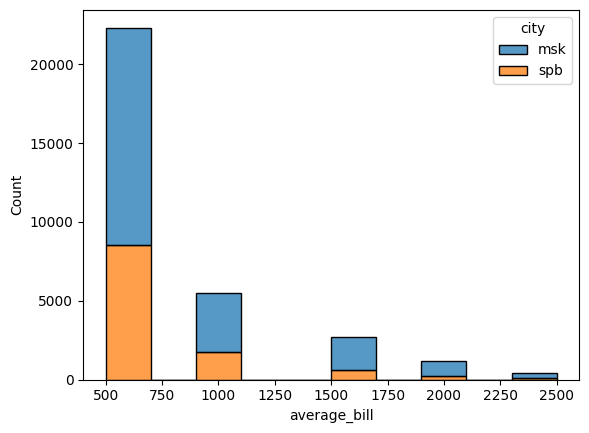

In [30]:
import seaborn as sns 

# Построение гистограммы с разделением по 'city'
sns.histplot(data_cleaned, x='average_bill', hue='city', bins = 10, multiple='stack')

In [44]:
# корреляция между 'rating' и 'average_bill'
data_cleaned[['average_bill', 'rating']].corr()

,average_bill,rating
average_bill,1.000000,0.090263
rating,0.090263,1.000000


In [1]:
import pandas as pd
data_cleaned = pd.read_csv('data_cleaned.csv')

In [2]:
from sklearn.model_selection import train_test_split 

clean_data_train, clean_data_test = train_test_split(
    data_cleaned, stratify=data_cleaned['average_bill'], test_size=0.33, random_state=42)

In [3]:
from scipy.stats import mode
from sklearn.base import RegressorMixin

In [29]:
from sklearn.base import RegressorMixin
import numpy as np

class MeanRegressor(RegressorMixin):
   # Predicts the mean of y_train
    def fit(self, y):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
            Training data features
        y : array like, shape = (_samples,)
            Training data targets
        '''
        self.mean_ = np.mean(y)
        self.is_fitted_ = True
        return self

    def predict(self, X):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
            Data to predict
        '''
        return np.full(shape=X.shape[0], fill_value=self.mean_) 
    
reg = MeanRegressor()
reg.fit(clean_data_train['average_bill'])
y_pred_base_reg = reg.predict(clean_data_test['average_bill'])

In [43]:
from sklearn.base import ClassifierMixin
import numpy as np
from scipy.stats import mode
    
class MostFrequentClassifier(ClassifierMixin):
 
    def fit(self, X, y):
       
        self.mode_ = mode(y)[0]
        self.is_fitted_ = True
        return self

    def predict(self, X):
        
        return np.full(shape=X.shape[0], fill_value=self.mode_)

mfc = MostFrequentClassifier().fit(clean_data_train['average_bill'],clean_data_train['average_bill']).predict(clean_data_train['average_bill'])

In [32]:
from sklearn.base import RegressorMixin
import numpy as np
import pandas as pd

class CityMeanRegressor(RegressorMixin):
    def __init__(self):
        self.city_mean_dict = None  # Словарь для хранения средних значений по городам

    def fit(self, X, y):
        # Создаем DataFrame на основе X и y для удобства обработки
        data = pd.DataFrame({'city': X['city'], 'average_bill': y})
        
        # Вычисляем средние значения average_bill для каждого города
        self.city_mean_dict = data.groupby('city')['average_bill'].mean().to_dict()
        return self

    def predict(self, X):
        # Предсказываем среднее значение по городу для каждого заведения
        predictions = [self.city_mean_dict[city] if city in self.city_mean_dict else 0 for city in X['city']]
        return np.array(predictions)

In [34]:
cmr = CityMeanRegressor().fit(clean_data_train, clean_data_train['average_bill'])
y_pred_cmr = cmr.predict(clean_data_test)

In [36]:
# Сравним по рмсе cmr и y_pred

from sklearn.metrics import mean_squared_error

print(mean_squared_error(clean_data_test['average_bill'], y_pred_base_reg))

print(mean_squared_error(clean_data_test['average_bill'], y_pred_cmr))


201344.60285540455
198119.64335056383


Поручинившись немного, возьмём на вооружение другую идею. Давайте использовать типы заведений! 

Но с типами есть некоторая проблема: в столбце ``rubrics_id`` не всегда один идентификатор, часто их несколько, и всего комбинаций довольно много. Чтобы не возиться с малочисленными типами, давайте сольём их в один безликий ``other``.

Итак, добавьте в обучающие и тестовые данные столбец ``modified_rubrics``, в котором будет то же, что и в ``rubrics_id``, если соответствующая комбинация рубрик содержит хотя бы 100 заведений из обучающей (!) выборки, и строка ``other`` в противном случае.

Здесь вам поможет контейнер ``Counter`` из библиотеки ``collections``.

In [4]:
from collections import Counter
aggregate = Counter(data_cleaned['rubrics_id'])
aggregate

Counter({"['30776']": 3990,
         "['30774']": 3941,
         "['31495']": 2519,
         "['30771']": 2335,
         "['30774', '30776']": 1690,
         "['30776', '30774']": 1683,
         "['30770']": 1540,
         "['30774', '30771']": 728,
         "['30777']": 710,
         "['30775']": 694,
         "['30770', '30776']": 611,
         "['30774', '31495']": 604,
         "['30771', '30774']": 567,
         "['30776', '30770']": 534,
         "['30776', '30771']": 467,
         "['31401']": 435,
         "['31375']": 409,
         "['30519']": 367,
         "['31495', '30774']": 345,
         "['30774', '30777']": 288,
         "['30771', '30776']": 266,
         "['30774', '30770']": 253,
         "['31350']": 214,
         "['30770', '30774']": 198,
         "['30777', '30774']": 186,
         "['31375', '30776']": 170,
         "['30776', '30775']": 159,
         "['30776', '31375']": 148,
         "['3501750896']": 139,
         "['30776', '31495']": 131,
         "['3077

In [24]:
# тут я смотрел сколько максимально может быть типов заведений в одном
import ast
data_cleaned['rubrics_id'].apply(lambda x: len(ast.literal_eval(x))).max()

6

In [5]:
clean_data_train['modified_rubrics'] = clean_data_train['rubrics_id'].apply(lambda x: 'other' if aggregate[x] < 100 else x)
clean_data_test['modified_rubrics'] = clean_data_test['rubrics_id'].apply(lambda x: 'other' if aggregate[x] < 100 else x)
 

Теперь настало время написать могучий классификатор, который по заведению предсказывает медиану средних чеков среди тех в обучающей выборке, у которых с ним одинаковые `modified_rubrics` и город (вы спросите, почему медиану, а не самый частый -- спишем это на вдохновение; самый частый тоже можно брать - но медиана работает лучше).

In [39]:
# Это тоже правильно, но моё и после правок 
from sklearn.base import ClassifierMixin
import numpy as np

class RubricCityMedianClassifier(ClassifierMixin):
    def __init__(self):
        self.city_rubrics_median_dict = None

    def fit(self, X, y):
        data = pd.DataFrame({
            'modified_rubrics':X['modified_rubrics'].apply(lambda x: tuple(x)),
            'city': X['city'], 
            'average_bill': y})

        self.city_rubrics_median_dict = data.groupby(['city','modified_rubrics'])['average_bill'].median()
        self.is_fitted_ = True
        return self

    def predict(self, X):
        pred = [self.city_rubrics_median_dict.get((city, tuple(rubric)), 0) for city, rubric in zip(X['city'], X['modified_rubrics'])]
        return np.array(pred)


In [40]:
y_pred_rcmc = RubricCityMedianClassifier().fit(clean_data_train, clean_data_train['average_bill']).predict(clean_data_test)

In [19]:
# RubricCityMedianClassifier
import pandas as pd
import numpy as np
from sklearn.base import ClassifierMixin

class RubricCityMedianClassifier(ClassifierMixin):
    def __init__(self):
        self.city_rubrics_median_dict = None
        self.is_fitted_ = False

    def fit(self, X, y):
        # Преобразуем rubrics в строковое представление для надёжного использования в качестве ключей
        data = pd.DataFrame({
            'modified_rubrics': X['modified_rubrics'].apply(lambda x: tuple(x)),  # Преобразуем списки в кортежи
            'city': X['city'], 
            'average_bill': y
        })

        # Группируем по городу и рубрикам (в виде кортежей)
        self.city_rubrics_median_dict = data.groupby(['city', 'modified_rubrics'])['average_bill'].median()
        self.is_fitted_ = True
        return self

    def predict(self, X):
        if not self.is_fitted_:
            raise ValueError("The model is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.")

        # Преобразуем rubrics в кортежи и делаем предсказание
        pred = [
            self.city_rubrics_median_dict.get((city, tuple(rubric)), np.median(self.city_rubrics_median_dict)) 
            for city, rubric in zip(X['city'], X['modified_rubrics'])
        ]
        return np.array(pred)


In [24]:
rcmc = RubricCityMedianClassifier()
rcmc.fit(clean_data_train,clean_data_train['average_bill'])
y_pred = rcmc.predict(clean_data_test)


In [10]:
data = pd.DataFrame({'modified_rubrics':clean_data_train['modified_rubrics'],'city': clean_data_train['city'], 'average_bill': clean_data_train['average_bill']})
data_dict_view = data.groupby(['city','modified_rubrics'])['average_bill'].median().to_dict()
data_dict_view

{('msk', "['30519', '30774']"): 500.0,
 ('msk', "['30519']"): 500.0,
 ('msk', "['30770', '30774']"): 500.0,
 ('msk', "['30770', '30776']"): 1000.0,
 ('msk', "['30770']"): 500.0,
 ('msk', "['30771', '30774']"): 500.0,
 ('msk', "['30771', '30776']"): 500.0,
 ('msk', "['30771']"): 500.0,
 ('msk', "['30774', '30519']"): 500.0,
 ('msk', "['30774', '30770', '30776']"): 1000.0,
 ('msk', "['30774', '30770']"): 500.0,
 ('msk', "['30774', '30771']"): 500.0,
 ('msk', "['30774', '30776', '30771']"): 500.0,
 ('msk', "['30774', '30776']"): 1000.0,
 ('msk', "['30774', '30777']"): 500.0,
 ('msk', "['30774', '31375']"): 500.0,
 ('msk', "['30774', '31495']"): 500.0,
 ('msk', "['30774']"): 500.0,
 ('msk', "['30775', '30776']"): 1000.0,
 ('msk', "['30775']"): 500.0,
 ('msk', "['30776', '30770']"): 1000.0,
 ('msk', "['30776', '30771', '30774']"): 500.0,
 ('msk', "['30776', '30771']"): 500.0,
 ('msk', "['30776', '30774']"): 1000.0,
 ('msk', "['30776', '30775']"): 500.0,
 ('msk', "['30776', '31375']"): 500.0

Сравните обученный классификатор по метрикам RMSE и balanced_accuracy_score с нашими бейзлайнами. Получилось ли улучшить?

In [44]:
from sklearn.metrics import mean_squared_error, accuracy_score, balanced_accuracy_score

print(mean_squared_error(clean_data_test['average_bill'], y_pred_rcmc))
print(mean_squared_error(clean_data_test['average_bill'], y_pred_cmr))
print(mean_squared_error(clean_data_test['average_bill'], y_pred_base_reg))
print(balanced_accuracy_score(clean_data_test['average_bill'], y_pred_rcmc))


153536.06789250355
198119.64335056383
201344.60285540455
0.3073310992848548


Бейзлайны у нас слишком просты и потому не очень полезны в жизни. Но если сложность модели растёт бесконтрольно, то тоже получается плохо.

Давайте рассмотрим конкретный пример. Создадим классификатор, использующий одновременно `rubrics_id` и `features_id`. 

Сделайте следующее:

- для каждого объекта обучающей выборки сконкатенируйте строку `rubrics_id` с разделителем (например, буквой 'q') и содержимым `features_id`. Полученный столбец озаглавьте `modified_features`. Это не самый клёвый способ заиспользовать все фичи, но сейчас пока сойдёт. Причём на сей раз не будем выкидывать мало представленные значения (вся информация важна, не так ли?).
- при этом для тестовой выборке заменяйте на строку `other` все конкатенации, которые не встретились в обучающей выборке.

То есть элементы в этом столбце будут иметь вид `other` или `30776 30774 q 3502045032 11741 3502045016 1046...`.

Теперь обучите классификатор, который для заведения предсказывает медиану среднего чека по всем объектам тестовой выборки с таким же, как у него, значением `modified_features`, а если такого в обучающей выборке нет, то глобальную медиану среднего чека по всей обучающей выборке.

**9. (2 балла) Загрузите в Контест предсказания этого классификатора на тестовой выборке**

Мы ждём файла **.csv**, у которого в каждой строке будет только одно число - предсказание классификатора.

Возможно, вам будет полезна библиотека ``tqdm``, позволяющая отслеживать в реальном времени, сколько времени уже крутится цикл и сколько итераций ещё осталось. Впрочем, если вы всё написали нормально, то должно работать не очень долго.

In [5]:
import pandas as pd
# data_cleaned = pd.read_csv('data_cleaned.csv')
from sklearn.model_selection import train_test_split 
data_cleaned = data.dropna(subset=['average_bill'])
data_cleaned = data_cleaned.loc[data_cleaned['average_bill']<=2500]
data = pd.read_csv('organisations.csv')
clean_data_train, clean_data_test = train_test_split(
    data_cleaned, stratify=data_cleaned['average_bill'], test_size=0.33, random_state=42)

In [6]:
clean_data_train['modified_features'] = clean_data_train['rubrics_id'] + ' q ' + clean_data_train['features_id']
clean_data_test['modified_features'] = clean_data_test['rubrics_id'] + ' q ' + clean_data_test['features_id']
clean_data_test['modified_features'] = clean_data_test['modified_features'].apply(lambda x: 'other' if x not in clean_data_train['modified_features'].values else x)

,org_id,city,average_bill,rating,rubrics_id,features_id,modified_features
45769,3276960721840719260,msk,500.0,4.500000,30770,11704 20422 1018 11177 1416 11867 10462,30770 q 11704 20422 1018 11177 1416 11867 10462
39061,8452997364765928283,msk,1500.0,4.442623,30774 30776,1415 3501481355 1416 11629 10462 1524 20422 11...,30774 30776 q 1415 3501481355 1416 11629 10462...


In [7]:
clean_data_test['modified_features'] = clean_data_test['rubrics_id'] + ' q ' + clean_data_test['features_id']
clean_data_test['modified_features'] = clean_data_test['modified_features'].apply(lambda x: 'other' if x not in clean_data_train['modified_features'].values else x)

In [8]:
import pandas as pd
import numpy as np
from sklearn.base import ClassifierMixin

class DifficultClassifier(ClassifierMixin):
    def __init__(self):
        self.median_group_dict = None
        self.is_fitted_ = False
    
    def fit(self, X, y):
        data = pd.DataFrame({
            'modified_features': X['modified_features'],
            'average_bill': y
        })

        self.median_group_dict = data.groupby('modified_features')['average_bill'].median()
        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        pred = [
            self.median_group_dict.get(rubric, np.median(self.median_group_dict)) 
            for rubric in X['modified_features']
        ]
        return np.array(pred)

dc = DifficultClassifier().fit(clean_data_train, clean_data_train['average_bill']).predict(clean_data_test).astype(int)
dc

array([500, 500, 500, ..., 500, 500, 500])

In [9]:
dc_t = DifficultClassifier().fit(clean_data_train, clean_data_train['average_bill']).predict(clean_data_train).astype(int)

In [37]:
clean_data_test.reset_index()
ind = clean_data_test.index.values.tolist()


[65841,
 48882,
 33711,
 33544,
 35293,
 13992,
 40502,
 28701,
 1650,
 17302,
 573,
 52840,
 56738,
 22463,
 32056,
 36425,
 19784,
 44555,
 34608,
 66126,
 57252,
 31979,
 56559,
 39879,
 40212,
 45973,
 18076,
 65960,
 46982,
 48524,
 50586,
 52122,
 61550,
 23165,
 25954,
 46849,
 41301,
 66615,
 52170,
 62535,
 18209,
 51891,
 64539,
 55389,
 25002,
 55690,
 66674,
 63981,
 23997,
 1500,
 42157,
 303,
 44536,
 63158,
 57650,
 65702,
 25373,
 43845,
 47498,
 64167,
 37517,
 50756,
 53757,
 32174,
 67373,
 32622,
 44029,
 1874,
 64879,
 44301,
 49636,
 29582,
 63891,
 57824,
 53206,
 64058,
 56313,
 63879,
 52852,
 58015,
 63320,
 66123,
 65523,
 38288,
 62829,
 52974,
 49035,
 10763,
 64779,
 44505,
 57044,
 29135,
 40241,
 38261,
 17554,
 61654,
 46149,
 58408,
 54585,
 1306,
 61286,
 67256,
 26718,
 54652,
 43173,
 66610,
 63622,
 32400,
 63724,
 51712,
 80,
 33253,
 59363,
 31995,
 40806,
 60242,
 44210,
 68267,
 30396,
 39540,
 51342,
 43563,
 1038,
 557,
 28935,
 47459,
 52365

In [38]:
dc_p = pd.DataFrame({'ind':ind,'dcp':dc})

In [39]:
dc_p.to_csv('dc_p.csv', index=False, header=None)

In [10]:
from sklearn.metrics import mean_squared_error, balanced_accuracy_score
import numpy as np
print(np.sqrt(mean_squared_error(clean_data_train['average_bill'], dc_t)))
print(balanced_accuracy_score(clean_data_train['average_bill'], dc_t))
print(np.sqrt(mean_squared_error(clean_data_test['average_bill'], dc)))
print(balanced_accuracy_score(clean_data_test['average_bill'], dc))

32.4162067388783
0.9931928777769354
513.9898108867789
0.2010249213051401


C:\Users\1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\1\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


### 11 задача

In [22]:
import pandas as pd
# data_cleaned = pd.read_csv('data_cleaned.csv')
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder


data = pd.read_csv('organisations.csv')
data_cleaned = data.dropna(subset=['average_bill'])
data_cleaned = data_cleaned.loc[data_cleaned['average_bill']<=2500]

# clean_data_train, clean_data_test = train_test_split(
#     data_cleaned, stratify=data_cleaned['average_bill'], test_size=0.33, random_state=42)

In [23]:
data_cleaned

,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...
2,8129364761615040323,msk,500.0,4.000000,31495,10462 11177 11617 11629 1416 1018 11704 11867 ...
3,15262729117594253452,msk,500.0,4.538813,30776 30770,3501618484 2020795524 11629 11617 1018 11704 2...
4,13418544315327784420,msk,500.0,4.409091,31495,11617 10462 11177 1416 11867 3501744275 20282 ...
...,...,...,...,...,...,...
68328,17662684569129497551,spb,1000.0,4.561707,30776,246 3501779478 1018 3501618484 3501481353 3501...
68329,5700899951016592061,msk,1500.0,4.377129,31401,3501773763 10462 1018 246 3501779478 350175479...
68330,4686040819909966338,msk,1500.0,3.666667,30776,10462 1189498238 11629 1416 1415 11741 3501481...
68331,12499715465202129892,msk,1500.0,4.554577,30770 30776 30774,273469383 10462 21247 1509 1416 3501618484 350...


In [24]:
import pandas as pd


# Шаг 1: Разделяем коды в столбцах на отдельные элементы (списки)
data_cleaned['rubrics_id'] = data_cleaned['rubrics_id'].str.split(' ')
data_cleaned['features_id'] = data_cleaned['features_id'].str.split(' ')

# Шаг 2: Разворачиваем списки в столбцах для каждого кода
df_exploded_rubrics = data_cleaned.explode('rubrics_id')
df_exploded_features = data_cleaned.explode('features_id')

# Шаг 3: Применяем One-Hot Encoding для обоих столбцов
encoded_rubrics = pd.get_dummies(df_exploded_rubrics['rubrics_id'], prefix='rubric')
encoded_features = pd.get_dummies(df_exploded_features['features_id'], prefix='feature')

# Шаг 4: Возвращаем к изначальному количеству строк с помощью groupby и суммирования
final_rubrics = encoded_rubrics.groupby(df_exploded_rubrics.index).sum()
final_features = encoded_features.groupby(df_exploded_features.index).sum()

# Шаг 5: Объединяем итоговые данные
final_df = pd.concat([data_cleaned, final_rubrics, final_features], axis=1)


In [ ]:
final_df

In [26]:
final_df = final_df.drop(['org_id','rubrics_id','features_id'],axis=1)


In [27]:
final_df

,city,average_bill,rating,rubric_30519,rubric_30770,rubric_30771,rubric_30774,rubric_30775,rubric_30776,rubric_30777,...,feature_840026756,feature_840026757,feature_856448080,feature_873,feature_883,feature_948581684,feature_956,feature_980,feature_983,feature_995
0,msk,1500.0,4.270968,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,msk,500.0,4.375000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,msk,500.0,4.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,msk,500.0,4.538813,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,msk,500.0,4.409091,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68328,spb,1000.0,4.561707,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
68329,msk,1500.0,4.377129,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68330,msk,1500.0,3.666667,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
68331,msk,1500.0,4.554577,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
final_df = pd.get_dummies(final_df, columns=['city'])
final_df

,average_bill,rating,rubric_30519,rubric_30770,rubric_30771,rubric_30774,rubric_30775,rubric_30776,rubric_30777,rubric_3108292683,...,feature_856448080,feature_873,feature_883,feature_948581684,feature_956,feature_980,feature_983,feature_995,city_msk,city_spb
0,1500.0,4.270968,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,True,False
1,500.0,4.375000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,False
2,500.0,4.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,False
3,500.0,4.538813,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,True,False
4,500.0,4.409091,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68328,1000.0,4.561707,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,False,True
68329,1500.0,4.377129,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,True,False
68330,1500.0,3.666667,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,True,False
68331,1500.0,4.554577,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,True,False


In [2]:
# data_cleaned['features_id']=data_cleaned['features_id'].str.split(' ')
# data_cleaned['rubrics_id']=data_cleaned['rubrics_id'].str.split(' ')


In [29]:
clean_data_train, clean_data_test = train_test_split(
    final_df, stratify=final_df['average_bill'], test_size=0.33, random_state=42)

In [31]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier()
clf.fit(clean_data_train.drop('average_bill', axis = 1), clean_data_train['average_bill'])

Learning rate set to 0.092536
0:	learn: 1.4358539	total: 127ms	remaining: 2m 6s
1:	learn: 1.3178149	total: 168ms	remaining: 1m 23s
2:	learn: 1.2255019	total: 212ms	remaining: 1m 10s
3:	learn: 1.1530432	total: 256ms	remaining: 1m 3s
4:	learn: 1.0958719	total: 298ms	remaining: 59.3s
5:	learn: 1.0448336	total: 340ms	remaining: 56.3s
6:	learn: 1.0040965	total: 382ms	remaining: 54.1s
7:	learn: 0.9694038	total: 418ms	remaining: 51.9s
8:	learn: 0.9390507	total: 465ms	remaining: 51.2s
9:	learn: 0.9146158	total: 506ms	remaining: 50.1s
10:	learn: 0.8913954	total: 544ms	remaining: 49s
11:	learn: 0.8691033	total: 584ms	remaining: 48.1s
12:	learn: 0.8523535	total: 618ms	remaining: 47s
13:	learn: 0.8368867	total: 657ms	remaining: 46.3s
14:	learn: 0.8217817	total: 723ms	remaining: 47.5s
15:	learn: 0.8063751	total: 762ms	remaining: 46.8s
16:	learn: 0.7951822	total: 798ms	remaining: 46.1s
17:	learn: 0.7848840	total: 830ms	remaining: 45.3s
18:	learn: 0.7738228	total: 867ms	remaining: 44.8s
19:	learn: 0.

In [32]:
from sklearn.metrics import balanced_accuracy_score
clf_pred = clf.predict(clean_data_test.drop('average_bill', axis = 1))
print(balanced_accuracy_score(clean_data_test['average_bill'], clf_pred))

0.3655587686764977
